# ***E-commerce Sales Analysis: Optimizing Products and Segmenting Customers***

## ***Project Overview:***
### This project analyzes sales data from an online craft store [Online Retail Store](/kaggle/input/tata-online-retail-dataset) to identify top products, seasonal trends, and customer segments while offering actionable recommendations to optimize inventory and boost profitability.

## Key Objectives:

+ *Identify key patterns in product sales and customer behaviors, target underperforming segments, and provide actionable insights to enhance marketing and sales strategies.*
+ *Segment customers using RFM (Recency, Frequency, Monetary) analysis.*
+ *Provide data-driven recommendations and marketing strategies based on this analysis.*



## Content Table:
1. *Data preparation*
2. *Product Analysis*
3. *Sales Seasonality*
4. *RFM analysis*
5. *Conclusion and Recommendations*


In [3]:
import warnings

warnings.filterwarnings(
    "ignore",
    message=".*use_inf_as_na option is deprecated.*",
    category=FutureWarning,
)
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
#Libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns 
import datetime as dt
import plotly.express as px

color_palette = [
    "#4E79A7",   
    "#F28E2B",   
    "#E15759",  
    "#76B7B2",   
    "#59A14F",   
    "#EDC948",   
    "#B07AA1",   
    "#FF9DA7",   
    "#9C755F",   
    "#BAB0AC",   
]
sns.set_palette(color_palette)  
plt.rcParams['font.family'] = 'Roboto'  
plt.rcParams['font.size'] = 12 
plt.rcParams['axes.titlesize'] = 16 
plt.rcParams['axes.labelsize'] = 14 
plt.rcParams['figure.facecolor'] = '#F5F5F5'  
plt.rcParams['axes.facecolor'] = '#FFFFFF'  
plt.rcParams['grid.color'] = '#7F8C8D'  


## Data preparation
***I started by loading the sales data and performing several processes: removing missing or negative values, checking data types, and adding new columns for future analysis.***

In [5]:
# Import Data
df = pd.read_csv('/kaggle/input/tata-online-retail-dataset/Online Retail Data Set.csv',encoding='unicode_escape')


## ***Dataset Descripton***
### The dataset includes approximately 500,000 sales records with the following columns:
- **InvoiceNo**: *Unique transaction ID*
- **StockCode**: *Product identification ID*
- **Description**: *Product name*
- **Quantity**: *Number of items sold*
- **InvoiceDate**: *Purchase date*
- **UnitPrice**: *Price per item*
- **CustomerID**: *Unique customer identifier*
- **Country**: *Customer location*

In [6]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


## ***Data Cleaning***
### I have removed duplicate entries and fixed missing values to improve the quality and trustworthiness of the data.

### The dataset contains the following:  

- *Description: 1,454 missing values (NaN)*
- *CustomerID: 135,037 missing values (NaN)*

In [7]:

df.drop_duplicates(inplace = True)
df.dropna(subset = ['Description','CustomerID'], inplace =True)


### Anomalies, including negative **Quantity**, have been filtered out.

In [8]:
df = df[(df['Quantity'] > 0)]

### I converted the **InvoiceDate** to a datetime format for time-based analysis, and I changed **CustomerID** to an integer type.

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed')
df['CustomerID'] = df['CustomerID'].astype('Int64')


### I added a **Sales** column to calculate the total price of purchased items and defined **Month** and **MonthYear** from **InvoiceDate** for month-based analysis.

In [10]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
df['Date'] = df['InvoiceDate'].dt.to_period('M').astype(str)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850,United Kingdom,15.30,2010-01
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,2010-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850,United Kingdom,22.00,2010-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,2010-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850,United Kingdom,20.34,2010-01


## ***Exploratory Data Analysis(EDA)***
### At the beginning of EDA, I thought of making top_10 products to show best sellers, but as shown in the distribution of products,  the distribution is right-skewed and long-tailed, so simply looking at top sellers will not give me a full picture.

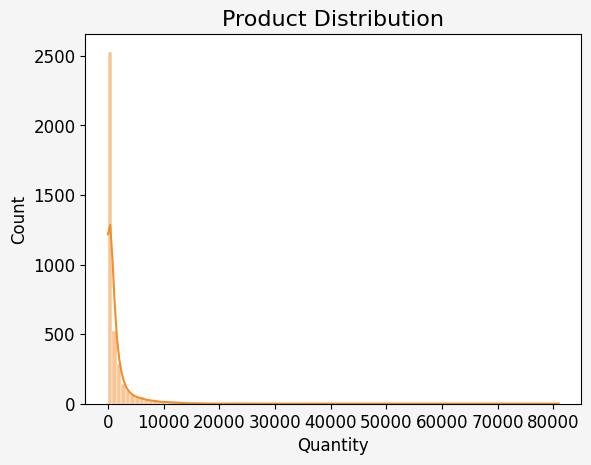

In [11]:
#Sales Distribution
product_sales = df.groupby('Description')['Quantity'].sum().sort_values(ascending = False).reset_index()

sns.histplot(product_sales['Quantity'],bins = 100, kde = True, color = color_palette[1], edgecolor = '#FFFFFF')
plt.title('Product Distribution', fontsize = 16)
plt.xlabel('Quantity',fontsize = 12)
plt.ylabel('Count',fontsize = 12)
plt.show()



### Instead, I applied a log transformation that helped reduce skewness and visualize the distribution more effectively. After this transformation, the log-transformed histogram appears more symmetric, with a peak between 6 and 8. 

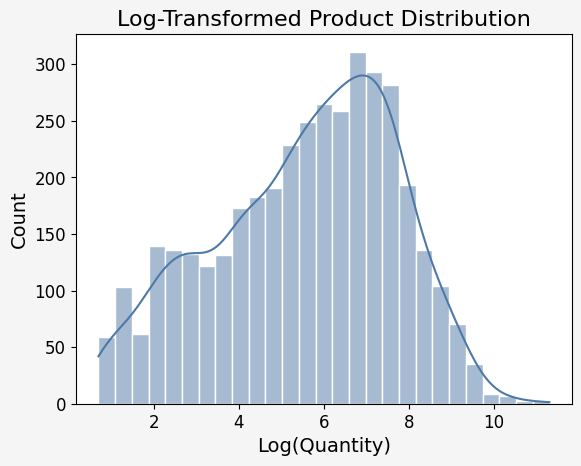

In [12]:
#Log Transformation
product_sales['log_quantity'] = np.log1p(product_sales['Quantity'])
sns.histplot(product_sales['log_quantity'], kde = True, color = color_palette[0], edgecolor = '#FFFFFF')
plt.title('Log-Transformed Product Distribution')
plt.xlabel('Log(Quantity)')
plt.show()

### To confirm the effect of the Pareto Principle, which states that a small number of products account for the majority of sales, I ranked the products based on total quantity sold and calculated the cumulative percentage of sales. As a result, I found that it took 878 products (22.6%) to achieve 80% of total sales.

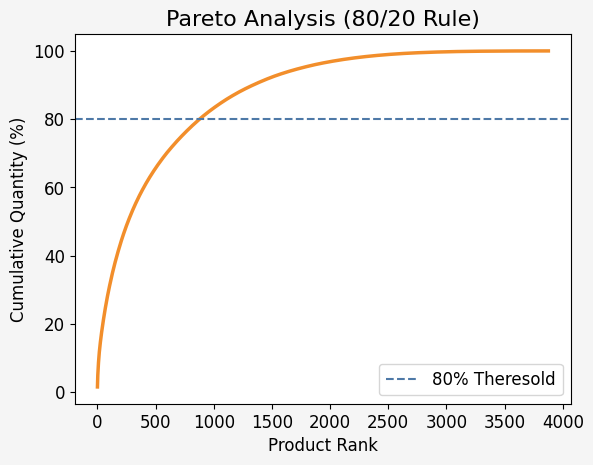

Products needed to reach 80% of total sales: 878 of 3877 total products.


In [13]:
#Pareto Analysis
product_sorted = product_sales.sort_values(by = 'Quantity', ascending = False). reset_index(drop = True)
product_sorted['c_quntity'] = product_sorted['Quantity'].cumsum()
product_total = product_sorted['Quantity'].sum()
product_sorted['c_percent'] = 100* product_sorted['c_quntity'] / product_total

plt.plot(product_sorted.index, product_sorted['c_percent'], color = color_palette[1], linewidth = 2.5)
plt.axhline(y = 80, color = color_palette[0], linestyle = '--', label = '80% Theresold')
plt.xlabel('Product Rank', fontsize =12)
plt.ylabel('Cumulative Quantity (%)', fontsize =12)
plt.title('Pareto Analysis (80/20 Rule)', fontsize =16)
plt.legend(loc='lower right')
plt.show()

top_80_index = product_sorted[product_sorted['c_percent'] <=80].index.max()
print(f"Products needed to reach 80% of total sales: {top_80_index + 1} of {len(product_sorted)} total products.")

### Now it's time to categorize products into groups based on the quantity sold, using a 10% division. The bottom decile of sales includes products sold between 1 and 10 units, while the top two deciles account for the highest proportion of total sales.

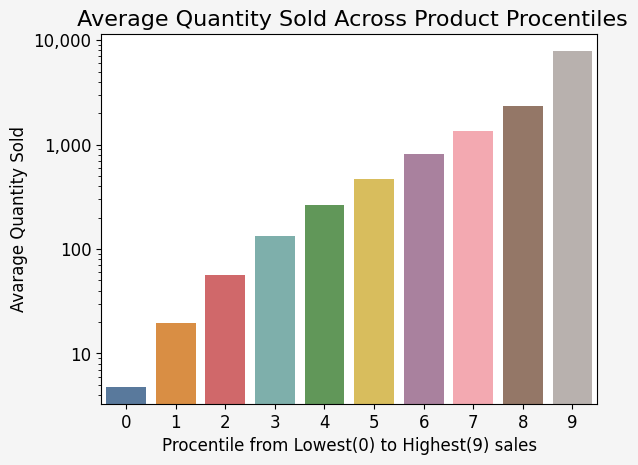

In [14]:
#Percentile Analysis
product_sorted['percentile'] = pd.qcut(product_sorted['Quantity'], q = 10, labels = False)
percentile_avg = product_sorted.groupby('percentile')['Quantity'].mean().reset_index()

sns.barplot(x = 'percentile', y = 'Quantity', data = percentile_avg, palette= color_palette[:len(percentile_avg['percentile'])])
plt.xlabel('Procentile from Lowest(0) to Highest(9) sales', fontsize =12)
plt.ylabel('Avarage Quantity Sold',fontsize =12)
plt.title(' Average Quantity Sold Across Product Procentiles', fontsize =16)
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.show()

### Based on the analysis, it is good idea to develop a tailored strategy for products that may not be worth retaining. The next step is to identify products with potential and those that can be customized effectively.

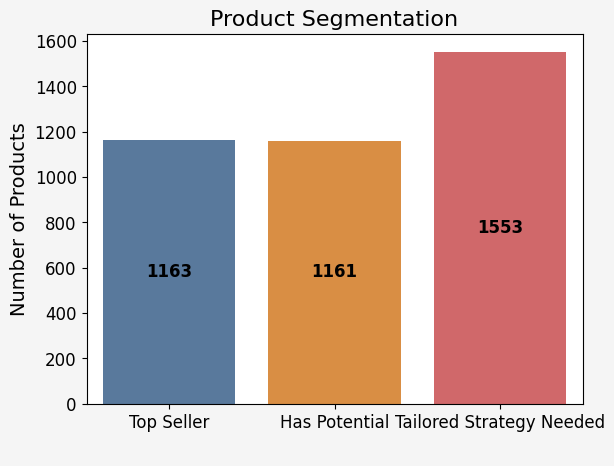

In [15]:
product_sorted['Segment'] = product_sorted['percentile'].apply(lambda x: 'Top Seller' if x >= 7 else ('Has Potential' if x >= 4 else 'Tailored Strategy Needed'))

ax = sns.countplot(x = 'Segment', data = product_sorted, order=['Top Seller','Has Potential','Tailored Strategy Needed'])
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2., p.get_height() / 2), 
                ha='center', va='center', 
                fontsize=12, fontweight='bold', color='black')
plt.xlabel(' ')
plt.ylabel('Number of Products')
plt.title('Product Segmentation')
plt.show()


### I analyzed monthly sales trends in two segments: Top Sellers and Has Potential. The Top Sellers showed significant growth and notable peaks in 2011, especially around mid-year and the year's end. In contrast, the "Has Potential" segment remained flat with only slight upward trends, showing little seasonal variation.


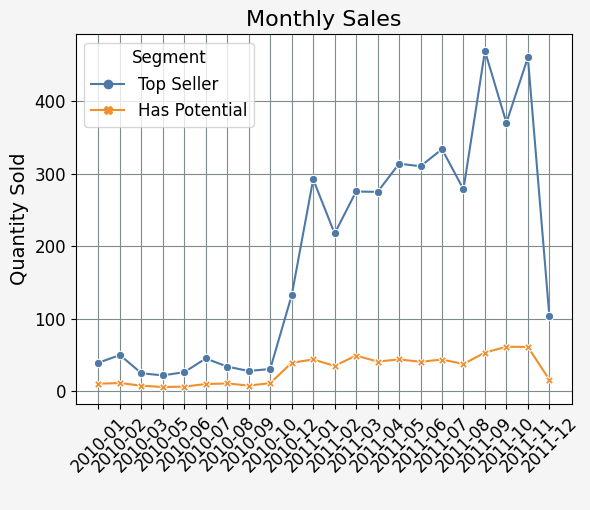

In [16]:
#Monthly sales
top_p = product_sorted[product_sorted['Segment'] == 'Top Seller']['Description']
potential_p = product_sorted[product_sorted['Segment'] == 'Has Potential']['Description']

def monthly_sales_f(df, p_list, segment):
    segment_sales = df[df['Description'].isin(p_list)]
    monthly_sales = segment_sales.groupby(['Date','Description'])['Quantity'].sum().reset_index()
    monthly_sales['Segment'] = segment

    return monthly_sales
    
monthly_top = monthly_sales_f(df,top_p, 'Top Seller')
monthly_potential = monthly_sales_f(df,potential_p, 'Has Potential')

combined_monthly_sales = pd.concat([monthly_top, monthly_potential]).sort_values('Date')

sns.lineplot(data= combined_monthly_sales, x='Date', y='Quantity', hue='Segment', style='Segment', markers=True, dashes=False,errorbar=None)
plt.title('Monthly Sales')
plt.xlabel(' ')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### To identify products with potential, I categorize them by seasonal popularity to determine which ones need extra promotion during each season.

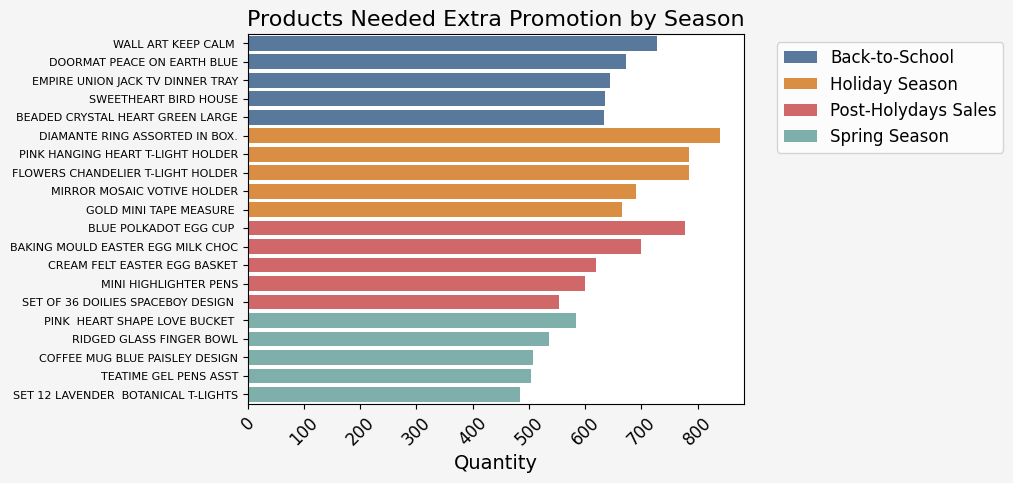

In [17]:
combined_monthly_sales['Date'] = pd.to_datetime(combined_monthly_sales['Date'])
def seasons(date):
    month = date.month
    if month in [10,11,12]:
        return 'Holiday Season'
    elif month in [1,2,3]:
        return 'Post-Holydays Sales'
    elif month in [4,5,6]:
        return 'Spring Season'
    elif month in [7,8,9]:
        return 'Back-to-School'
    else:
        return 'Other'

combined_monthly_sales['Season'] = combined_monthly_sales['Date'].apply(seasons)

season_sales = combined_monthly_sales[combined_monthly_sales['Segment'] == 'Has Potential']
u_product = season_sales.groupby(['Season', 'Description'])['Quantity'].sum().reset_index()
u_product['Rank'] = u_product.groupby('Season')['Quantity'].rank(method='first',ascending = False)
top5_season = u_product[u_product['Rank'] <=5]
top5_season = top5_season.sort_values(['Season','Quantity'], ascending=[True, False])

sns.barplot(data=top5_season, x='Quantity', y='Description', hue = 'Season', dodge = False)
plt.title('Products Needed Extra Promotion by Season')
plt.ylabel('')

plt.xticks(rotation=45)
plt.yticks(fontsize=8)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()


### Now, I check for the 10 best-selling products each season to ensure there are enough items available for sale.

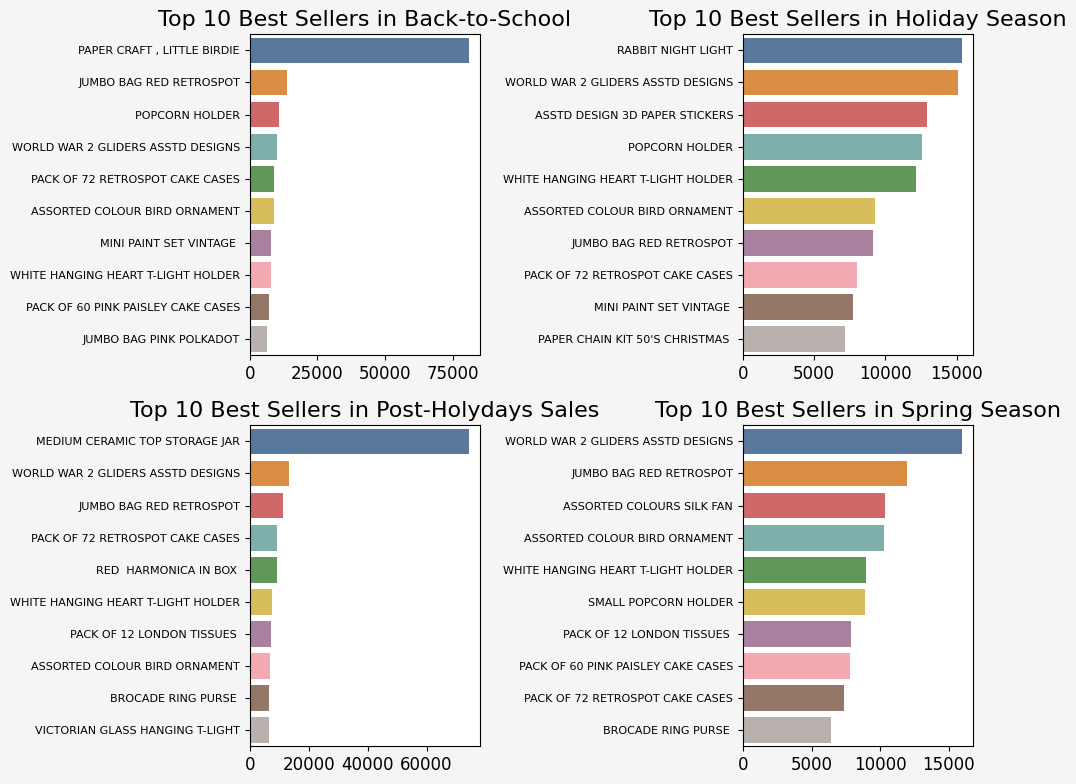

In [18]:
season_best_sellers = combined_monthly_sales[combined_monthly_sales['Segment'] == 'Top Seller']
best_sellers = season_best_sellers.groupby(['Season', 'Description'])['Quantity'].sum().reset_index()
best_sellers['Rank'] = best_sellers.groupby('Season')['Quantity'].rank(method='first',ascending = False)
top10_season = best_sellers[best_sellers['Rank'] <=10]
top10_season = top10_season.sort_values(['Season','Quantity'], ascending=[True, False])

seasons = top10_season['Season'].unique()

fig, axes = plt.subplots(2,2,figsize=(10,8))
axes = axes.flatten()

for i,s in enumerate(seasons):
     sns.barplot(x = 'Quantity', y = 'Description',data = top10_season[top10_season['Season'] == s], ax=axes[i])
     axes[i].set_title(f'Top 10 Best Sellers in {s}')
     axes[i].tick_params(axis='y', labelsize=8)
     axes[i].set_xlabel('')
     axes[i].set_ylabel('')
plt.tight_layout()
plt.show()

### I analyzed product performance by country and added it to Tableau for better visualization.

In [19]:
products_by_country = df.groupby(['Country','Description'])['Quantity'].sum().reset_index()
products_by_country['Rank'] = products_by_country.groupby('Country')['Quantity'].rank(method = 'dense', ascending =False)
products_by_country['Performing'] = products_by_country['Rank'].apply(lambda x: 'Top Performer' if x <= 37 else ('General performer' if x <= 225 else 'Underperformer'))
products_by_country['Performing'].unique()

array(['General performer', 'Top Performer', 'Underperformer'],
      dtype=object)

## ***Recency, Frequency, Monetary(RFM) analysis***
### Segmented customers based on recency (days since last purchase), frequency (number of purchases), and monetary (total spending) metrics.

In [20]:
# RFM metrics

snap_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
rfm = df.groupby('CustomerID').agg({'InvoiceDate':lambda x: (snap_date - x.max()).days, 'InvoiceNo': 'count', 'Sales': 'sum'}).rename(columns = {
    'InvoiceDate' : 'Recency',
    'InvoiceNo' : 'Frequency',
    'Sales' : 'Monetary'
})



In [21]:
#RFM normalization

rfm['R'] = pd.qcut(rfm['Recency'], 5, labels = [5,4,3,2,1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method ='first'), 5, labels = [5,4,3,2,1])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels = [5,4,3,2,1])
rfm['RFM_score'] = rfm['R'].astype(str)+rfm['F'].astype(str)+rfm['M'].astype(str)

### I applied six different customer segments, from **VIP**'s (customers with the highest RFM) to **Inactive** customers (one-time buyers with low RFM).

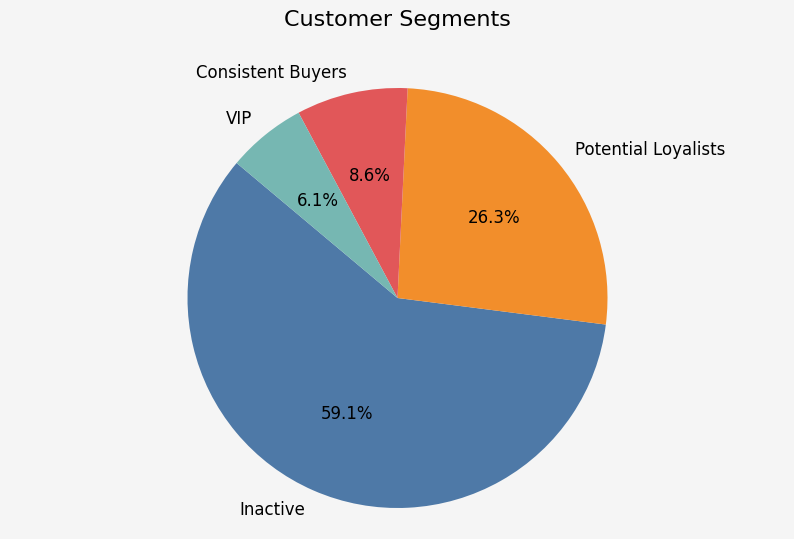

In [22]:
#Customer Segmentation

def customer_segment(row):
    r,f,m = row['R'], row['F'],row['M']

    if r >= 4 and f >= 4 and m >= 4:
        return 'VIP'
    elif r >= 3 and f >= 4 and m >= 3:
        return 'Consistent Buyers'
    elif r >= 2 and f >= 3 and m >= 2:
        return 'Potential Loyalists'
    else:
        return 'Inactive'

rfm['Segment'] = rfm.apply(customer_segment, axis=1)

segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(10,6))
plt.pie(segment_counts.values, labels = segment_counts.index, autopct = '%1.1f%%', startangle = 140)
plt.title('Customer Segments', pad = 30)
plt.axis('equal')
plt.show()


### Based on the heatmap, we can outline the following strategy:

- **Bottom Right**: *These customers are super loyal and active, so we should reward them for their commitment.*
- **Top Right**: *This group has a high risk of churning, so we need to implement win-back strategies to retain them.*
- **Bottom Left**: *These are new or one-time buyers, and we should encourage them to make repeat purchases.*
- **Middle Cells**: *We should nurture and grow these customers to help them become more frequent buyers.*

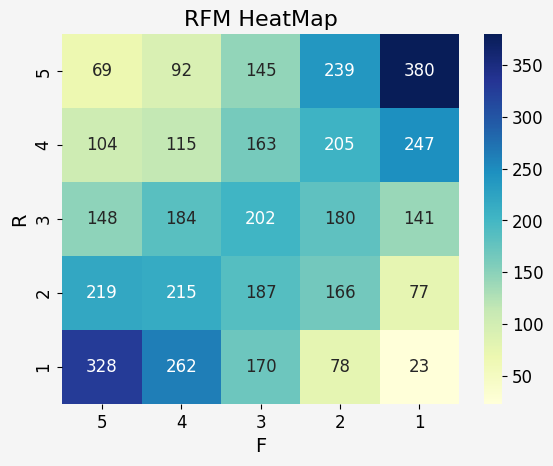

In [23]:
#Correlation heatmap

seg_counts = rfm.groupby(['R', 'F'],observed=False).size().unstack(fill_value=0)
sns.heatmap(seg_counts, annot=True, fmt='d',cmap='YlGnBu')
plt.title('RFM HeatMap')
plt.show()

## ***To summarize the data I receive from EDA and RFM, the key points for data-driven recommendations and marketing strategies are as follows:***

-  *Focus marketing and inventory efforts on top-selling products to maximize profit, while also developing strategies to promote and push products that show potential for growth.*

- *Utilize RFM-based segments to create targeted marketing campaigns that cater to the specific behaviors and needs of each customer group.*

- *Use seasonal distribution analyses to align promotions and inventory with peak demand periods.*

- *Identify opportunities to bundle or recommend complementary products based on top sellers and customer segments.*

- *Develop targeted re-engagement campaigns for inactive customers to help increase their loyalty.*

- *Tailor marketing efforts by analyzing product sales performance across different countries, ensuring that strategies are relevant and effective.*

In [24]:
#Downloads for dashboard
df.to_csv('cleand_data_retail.csv', index = False)
rfm.to_csv('rfm_data.csv')
products_by_country.to_csv('product_sales_by_country.csv', index =False)
